In [1]:
import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")

df = df.drop('IMAGERY_TITLE', axis = 1)
df1 = df1.drop('IMAGERY_TITLE', axis = 1)
df = pd.concat([df, df1], ignore_index = True)
df = df.dropna(axis = 0)


N_SAMPLES = int(df.shape[0]/196)
print(N_SAMPLES)

plot_ids = sorted(df['PLOT_ID'].unique())

336


In [3]:
df.head(5)

,PLOT_ID,SAMPLE_ID,LON,LAT,FLAGGED,ANALYSES,USER_ID,COLLECTION_TIME,ANALYSIS_DURATION,TREE
0,135191136,484051393,39.499458,14.078345,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
1,135191136,484051394,39.499458,14.078432,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
2,135191136,484051395,39.499458,14.078520,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
3,135191136,484051396,39.499458,14.078607,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0
4,135191136,484051397,39.499458,14.078694,False,1,jo.m.brandt@gmail.com,2019-09-10 14:15:33.03602,131.1,0.0


In [4]:
def calc_bbox(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])), (max(subs['LON']), max(subs['LAT']))]

locations = [calc_bbox(x) for x in plot_ids]
locations[0]

[(39.499457864411035, 14.078345324474359),
 (39.50062567428038, 14.079478055220802)]

In [5]:
def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]

In [6]:
def remove_blank_steps(array):
    to_update = {}
    sets = []
    for k in range(6):
        for i in range(array.shape[0]):
            for k in range(array.shape[-1]):
                mean = (np.mean(array[i, :, :, k]))
                if mean == 0:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
                if mean == 1:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
    for i in range(array.shape[0]):
        for k in range(array.shape[-1]):
            mean = (np.mean(array[i, :, :, k]))
            if mean == 0:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
            if mean == 1:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
    print(set(sets))
    return array

In [7]:
import os
image_size = 14

def ndvi(x):
    # (B8 - B4)/(B8 + B4)
    ndvis = [(im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + im[:, :, 2]) for im in x]
    min_ndvi = min([np.mean(x) for x in ndvis])
    max_ndvi = max([np.mean(x) for x in ndvis])
    ndvis = [(x - min_ndvi / (max_ndvi - min_ndvi)) for x in ndvis]
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 10] = ndvis[i]
    return x

# Initiate empty lists to store the X and Y data in
data_x = []
data_y = []
binary_y = []
data_location_x = []
data_location_y = []
lengths = []

# Iterate over each plot
pad = True
flip = True
for i in plot_ids:
    # Load the sentinel imagery
    x = np.load("../data/ids/" + str(i) + ".npy")
    # Shape check
    if x.shape[1] == image_size:
        x = ndvi(x)                # calc NDVI
        x = remove_blank_steps(x)
        y = reconstruct_images(i)
        if sum([sum(x) for x in y]) >= 1:
            binary_y.append(1)
        else:
            binary_y.append(0)
        lengths.append(x.shape[0])
        #x = np.median(x, axis = 0) # and calculate the median over the time steps
        if pad:
            if x.shape[0] < 24:
                print(x.shape[0])
                padding = np.zeros((24 - x.shape[0], image_size, image_size, 11))
                x = np.concatenate((x, padding), axis = 0)
        data_x.append(x)
        data_y.append(y)
        if flip:
                # FLIP HORIZONTAL
            x1 = np.flip(x, 1)
            data_x.append(x1)
            data_y.append(np.flip(y, 0))
            lengths.append(x.shape[0])
    
                # FLIP BOTH
            x2 = np.flip(x, 2)
            x2 = np.flip(x2, 1)
            data_x.append(x2)
            data_y.append(np.flip(y, [0, 1]))
            lengths.append(x.shape[0])
                # FLIP VERTICAL
            x3 = np.flip(x, 2)
            data_x.append(x3)
            data_y.append(np.flip(y, 1))
            lengths.append(x.shape[0])

data_x = np.stack(data_x)
data_y = np.stack(data_y)
data_y = np.reshape(data_y, (N_SAMPLES*4, 14, 14, 1))
binary_y = np.stack(binary_y)
lengths = np.stack(lengths)
lengths = np.reshape(lengths, (lengths.shape[0], 1))

set()
set()
22
set()
22
set()
22
set()
set()
22
set()
22
{6, 8, 9, 22, 23}
set()
22
set()
22
set()
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
{1, 2, 19}
set()
22
set()
22
{10, 12, 13}
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
{3, 4, 21}
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
set()
22
set()
22
set()
22
set()
set()
22
set()
22
set()
22
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
set()
set()
22
set()
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22
set()
22

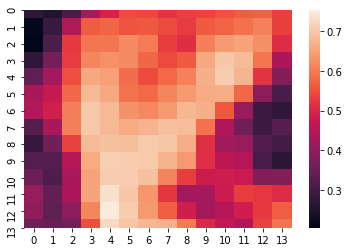

In [8]:
sns.heatmap(data_x[86, 16, :, :, 10]) # time 1, 

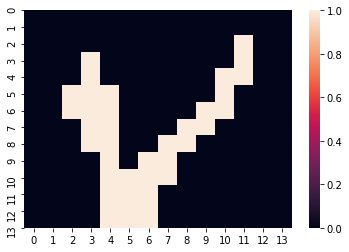

In [9]:
sns.heatmap(data_y[86].reshape(14, 14))

In [10]:
train_x = data_x[:int(len(data_x) * 0.8)]
train_y = data_y[:int(len(data_x) * 0.8)]
train_lengths = lengths[:int(len(data_x) * 0.8)]
train_binary = binary_y[:int(len(data_x) * 0.8)]

test_x = data_x[int(len(data_x) * 0.8):]
test_y = data_y[int(len(data_x) * 0.8):]
test_lengths = lengths[int(len(data_x) * 0.8):]
test_binary = binary_y[int(len(data_x) * 0.8):]

In [11]:
import tensorflow as tf
import numpy as np


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


def lovasz_hinge(logits, labels):
        """
        Binary Lovasz hinge loss
          logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
          labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
          per_image: compute the loss per image instead of per batch
          ignore: void class id
        """
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log = tf.reshape(log, (-1,))
            lab = tf.reshape(lab, (-1,))
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        losses.set_shape((None,))
        loss = tf.reduce_mean(losses)
        return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss

In [12]:
from keras import backend as K
import tensorflow as tf

def binary_focal_loss(gamma=2., alpha=.25):
    
    def binary_focal_loss_fixed(y_true, y_pred):

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

Using TensorFlow backend.


In [13]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jac_loss = (1 - jac) * smooth
    return jac_loss

def bin_foc(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(0.5 * K.pow(1. - pt_1, 2) * K.log(pt_1)) \
               -K.sum((1 - 0.5) * K.pow(pt_0, 2) * K.log(1. - pt_0))


def foc_jaccard(y_true, y_pred):
    jaccard_loss = jaccard_distance(y_true,y_pred)
    focal_loss = bin_foc(y_true, y_pred)
    summed = jaccard_loss + focal_loss
    return summed

def foc_lovasz(y_true, y_pred):
    #jaccard_loss = jaccard_distance(y_true, y_pred)
    lovasz = lovasz_hinge(y_pred, y_true)
    #pred_reshape = tf.reshape(y_pred, (-1, 14, 14))
    #true_reshape = tf.reshape(y_true, (-1, 14, 14))
    focal_loss = bin_foc(y_true, y_pred)
    summed = lovasz + focal_loss
    return summed
    

In [14]:
class ConvGRUCell(tf.nn.rnn_cell.RNNCell):
  """A GRU cell with convolutions instead of multiplications."""

  def __init__(self, shape, filters, kernel, activation=tf.tanh, normalize=False, data_format='channels_last', reuse=None):
    super(ConvGRUCell, self).__init__(_reuse=reuse)
    self._filters = filters
    self._kernel = kernel
    self._activation = activation
    self._normalize = normalize
    if data_format == 'channels_last':
        self._size = tf.TensorShape(shape + [self._filters])
        self._feature_axis = self._size.ndims
        self._data_format = None
    elif data_format == 'channels_first':
        self._size = tf.TensorShape([self._filters] + shape)
        self._feature_axis = 0
        self._data_format = 'NC'
    else:
        raise ValueError('Unknown data_format')

  @property
  def state_size(self):
    return self._size

  @property
  def output_size(self):
    return self._size

  def call(self, x, h):
    channels = x.shape[self._feature_axis].value

    with tf.variable_scope('gates'):
      inputs = tf.concat([x, h], axis=self._feature_axis)
      n = channels + self._filters
      m = 2 * self._filters if self._filters > 1 else 2
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, 'SAME', data_format=self._data_format)
      if self._normalize:
        r, u = tf.split(y, 2, axis=self._feature_axis)
        r = tf.contrib.layers.layer_norm(r)
        u = tf.contrib.layers.layer_norm(u)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.ones_initializer())
        r, u = tf.split(y, 2, axis=self._feature_axis)
      r, u = tf.sigmoid(r), tf.sigmoid(u)

    with tf.variable_scope('candidate'):
      inputs = tf.concat([x, r * h], axis=self._feature_axis)
      n = channels + self._filters
      m = self._filters
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, 'SAME', data_format=self._data_format)
      if self._normalize:
        y = tf.contrib.layers.layer_norm(y)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
      h = u * h + (1 - u) * self._activation(y)

    return h, h

In [15]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [16]:
import keras
from keras.models import Sequential, Model
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import *
from keras.layers import Flatten, Dense, Input
from keras.layers import Lambda
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import ELU



tf.reset_default_graph()
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

def conv_lstm_model():
    inp = Input(shape = (24, 14, 14, 11))
    lengths = Input(shape = (1,), dtype=tf.int32)
    length2 = tf.reshape(lengths, (-1,))
    
        
    with tf.variable_scope('medium'):
        cell_m = ConvGRUCell(shape = [14, 14],
                       filters = 64,
                       kernel = [3,3])
        state_m = Lambda(
        lambda x: tf.concat(
            tf.nn.bidirectional_dynamic_rnn(
                cell_m, cell_m, x, sequence_length = length2, dtype = tf.float32)[1], -1
            )
        )(inp)

    average = Lambda(
        lambda x: tf.reduce_mean(x, 1))(inp)
    
    encoding_out = keras.layers.Concatenate(axis=-1)([state_m, average,])
    padded = ReflectionPadding2D((1, 1))(encoding_out)
    fm = Conv2D(filters = 64,
                kernel_size = (3, 3), 
                padding = 'valid',
                )(padded)
    elu = ELU()(fm)
    padded = ReflectionPadding2D((1, 1))(elu)
    fm = Conv2D(filters = 64,
                kernel_size = (3, 3), 
                padding = 'valid',
                )(padded)
    elu = ELU()(fm)
    #norm = BatchNormalization()(elu)
    #padded = ReflectionPadding2D((1, 1))(elu_out)
    fm = Conv2D(filters = 1,
                kernel_size = (1, 1), 
                padding = 'valid',
                activation = 'sigmoid'
                )(elu)
    
    mod = Model(inputs = [inp, lengths],  outputs = fm)
    mod.summary()
    mod.compile(#loss=[jaccard_distance],
        loss = [foc_lovasz],
                optimizer= keras.optimizers.Adam(lr=0.001),  metrics=[competitionMetric2])
    return mod

m = conv_lstm_model()

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 14, 14, 1 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 14, 14, 128)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 14, 14, 11)   0           i

In [21]:
m.fit([train_x, train_lengths],
      train_y, 
      validation_data = (([test_x, test_lengths], test_y)),
      batch_size=32,
      epochs = 500,
      #class_weight=[0.1, 0.9],
)

Train on 1075 samples, validate on 269 samples
Epoch 1/500
1075/1075 [==============================] - 63s 59ms/step - loss: 279.4085 - competitionMetric2: 0.2619 - val_loss: 275.2411 - val_competitionMetric2: 0.4524
Epoch 2/500
1075/1075 [==============================] - 66s 61ms/step - loss: 283.6480 - competitionMetric2: 0.2614 - val_loss: 287.0893 - val_competitionMetric2: 0.4613
Epoch 3/500
1075/1075 [==============================] - 69s 64ms/step - loss: 280.4677 - competitionMetric2: 0.2564 - val_loss: 275.2962 - val_competitionMetric2: 0.4242
Epoch 4/500
1075/1075 [==============================] - 64s 60ms/step - loss: 277.5027 - competitionMetric2: 0.2493 - val_loss: 281.8675 - val_competitionMetric2: 0.3606
Epoch 5/500
1075/1075 [==============================] - 62s 58ms/step - loss: 282.2307 - competitionMetric2: 0.2496 - val_loss: 270.2976 - val_competitionMetric2: 0.4498
Epoch 6/500
1075/1075 [==============================] - 62s 58ms/step - loss: 273.3969 - competit

KeyboardInterrupt: 

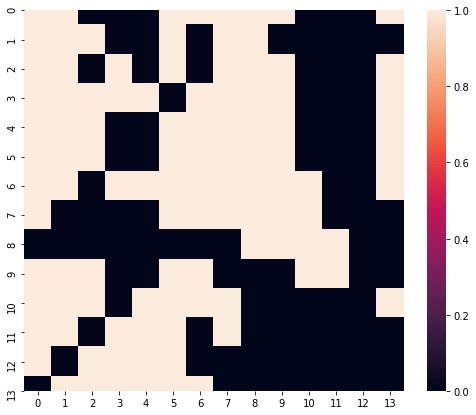

In [18]:
# 4 looks good, 0, 76, 90, 96, 108, 22, 56, 63, 55, 80

## 24, 98, 105, 15, 210, 235

plt.figure(figsize=(8.5, 7))
sns.heatmap(test_y[24].reshape(14, 14))

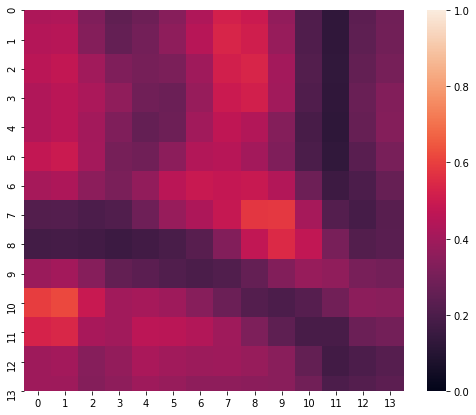

In [20]:
pred = m.predict([test_x[24].reshape(1, 24, 14, 14, 11), test_lengths[0]])
pred = pred.reshape(14, 14)
#pred[np.where(pred > 0.4)] = 1
#pred[np.where(pred < 0.5)] = 0

plt.figure(figsize=(8.5, 7))

# 111
sns.heatmap(pred, vmin=0, vmax=1)

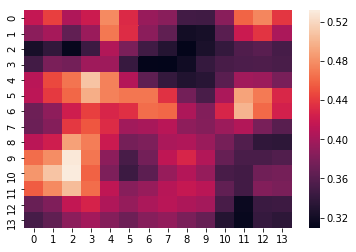

In [20]:
pred = m.predict([test_x[108].reshape(1, 24, 14, 14, 11), test_lengths[0]])
pred = pred.reshape(14, 14)
#pred[np.where(pred > 0.3)] = 1
#pred[np.where(pred > 0.4)] = 1


sns.heatmap(pred)

## PREDICT ON TEST WALL-TO-WALL

In [31]:
pred_x = []
pred_len = []
pred_files = ["../data/test/" + str(x) + ".npy" for x in range(0, 14)]
SHAPE_X = 7
SHAPE_Y = 2

In [32]:
pred_files

['../data/test/0.npy',
 '../data/test/1.npy',
 '../data/test/2.npy',
 '../data/test/3.npy',
 '../data/test/4.npy',
 '../data/test/5.npy',
 '../data/test/6.npy',
 '../data/test/7.npy',
 '../data/test/8.npy',
 '../data/test/9.npy',
 '../data/test/10.npy',
 '../data/test/11.npy',
 '../data/test/12.npy',
 '../data/test/13.npy']

In [33]:
for i in pred_files:
    data = np.load(i)
    data = ndvi(data)
    data = remove_blank_steps(data)
    pred_len.append(data.shape[0])
    if data.shape[0] < 24:
        padding = np.zeros((24 - data.shape[0], 14, 14, 11))
        data = np.concatenate((data, padding), axis = 0)
    pred_x.append(data)
pred_len = np.stack(pred_len).reshape((len(pred_len), 1))
    

{7, 8, 9, 10, 11, 14, 15}
{11}
{22}
{13, 14, 15}
{10, 12}
{6, 8, 9, 22, 23}
set()
{7, 8, 9, 10, 13, 14, 15}
{11}
set()
{13, 14, 15}
{10, 12, 23}
{6, 8, 9, 10, 13, 14, 15}
set()


In [34]:
preds = []
for i in range(0, SHAPE_X * SHAPE_Y):
    pr = m.predict([pred_x[i].reshape(1, 24, 14, 14, 11), pred_len[i]])
    pr = pr.reshape(14, 14)
    preds.append(pr)

row1 = np.concatenate(preds[:SHAPE_X], axis = 1)
row2 = np.concatenate(preds[SHAPE_X:], axis = 1)
row2.shape

(14, 98)

In [35]:
stacked = np.concatenate((row2, row1), axis = 0)
stacked.shape
#tacked = stacked.reshape((14, 70))
#stacked[np.where(stacked > 0.5)] = 1
#stacked[np.where(stacked < 0.5] = 0

(28, 98)

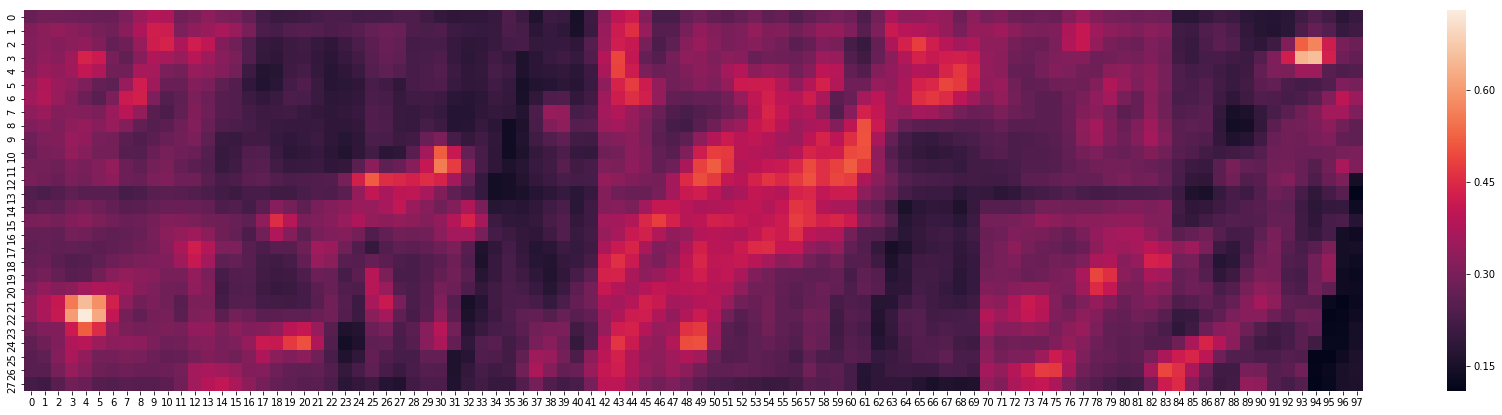

In [36]:
plt.figure(figsize=(30, 7))
sns.heatmap(stacked)

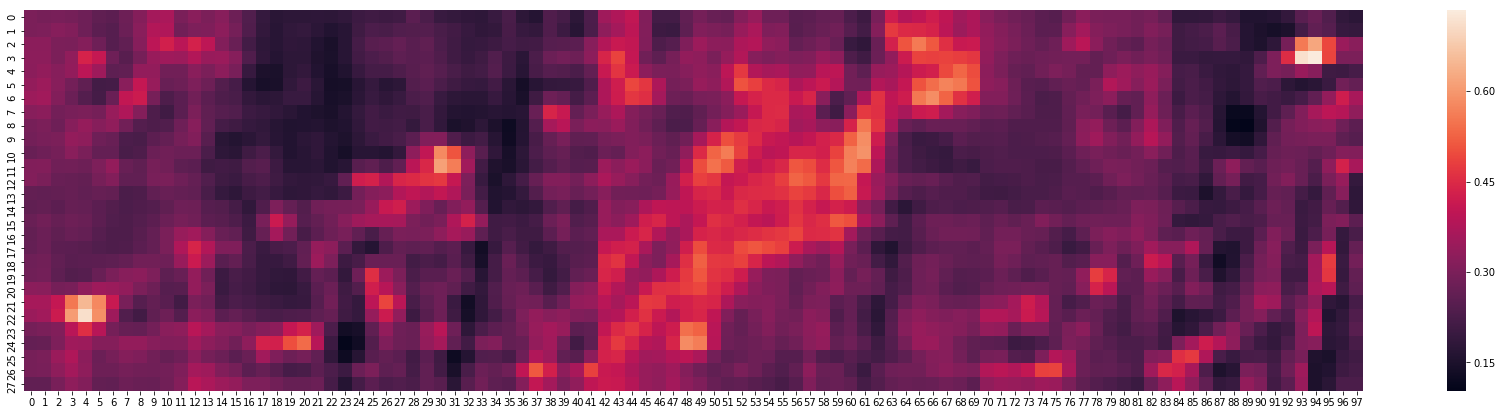

In [152]:
plt.figure(figsize=(30, 7))
sns.heatmap(stacked)